In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn import svm

In [2]:
icy = pd.read_excel("1880_2015\Sea_Ice_Index_Monthly_Data_by_Year_G02135_v3.0.xlsx", engine='openpyxl', index_col=0)
icy = icy.iloc[:,-1]
icy.head()

1978    12.673
1979    12.328
1980    12.337
1981    12.127
1982    12.447
Name: Annual, dtype: float64

In [3]:
meth = pd.read_csv("1880_2015\methane_1880_2014.csv", index_col=0).rename(columns={"data_mean_global":"methane_glob"})


In [4]:
sea_temp = pd.read_csv("1880_2015\data_ocean_temp.csv", index_col=0)
sea_temp = sea_temp.rename(columns={"Value":'sea_temp'})

<AxesSubplot:>

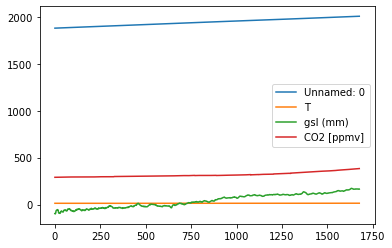

In [5]:
data = pd.read_csv("recent_tolledaten.csv", header=0)
data['T'] = data['T'] + 13.9
data.plot()


In [6]:
data['Unnamed: 0'] = data['Unnamed: 0'].astype('int32')
d = data.groupby(data['Unnamed: 0']).mean()

# label always stays the same
label = d.iloc[:,1]

# dc -> purely temperature and CO2 data
dc = d.drop(d.columns[[1]], 1)

# dm -> T, CO2, methane
dm = dc.join(meth)

# ds -> T, CO2, methane, sea_temp
ds = dc.join(meth).join(sea_temp)
ds.head()

# all data including SL
d = d.join(meth).join(sea_temp)
d


,T,gsl (mm),CO2 [ppmv],methane_glob,sea_temp
Unnamed: 0,,,,,
1880,13.795000,-78.234677,290.940476,868.696106,-0.03
1881,13.805385,-70.678826,291.555556,870.984131,-0.04
1882,13.763077,-82.428044,292.107692,873.250122,-0.03
1883,13.678462,-72.177368,292.557692,875.603149,-0.06
1884,13.634615,-61.008497,293.007692,878.148193,-0.17
...,...,...,...,...,...
2002,14.529231,157.772600,374.458462,1778.960938,0.48
2003,14.512308,169.276062,376.673846,1783.589844,0.55
2004,14.521538,165.759625,378.647692,1784.230225,0.50


In [7]:
# a shorter dataset including data about the global ice concentration 1977-2006
short_lab = dc.iloc[98:,1]
short_ds = ds.iloc[98:]
short_ds = short_ds.join(icy).rename(columns={"Annual":'ice_conc'})
short_ds.head()

,T,CO2 [ppmv],methane_glob,sea_temp,ice_conc
Unnamed: 0,,,,,
1978,14.064000,335.654000,1546.890869,0.12,12.673
1979,14.153077,337.730000,1566.160889,0.28,12.328
1980,14.198462,339.421538,1584.940796,0.20,12.337
1981,14.160000,340.548462,1602.650635,0.24,12.127
1982,14.168462,341.903846,1618.730591,0.23,12.447


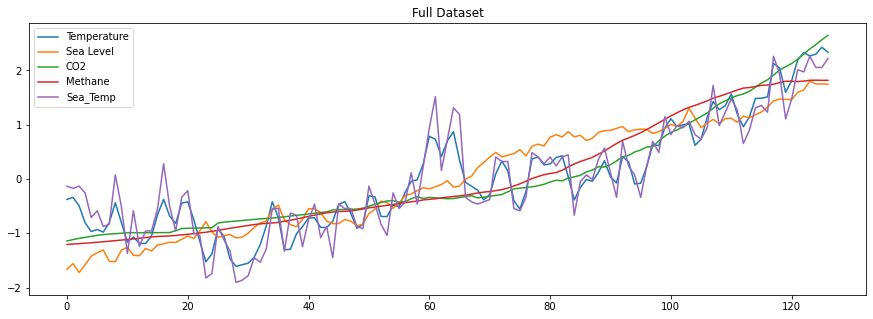

In [8]:
#pretty plot of all cofactors
scaler = StandardScaler()
scaler = scaler.fit(d)
fig, ax = plt.subplots(figsize=(15,5))
plt.title('Full Dataset')
ax.legend((plt.plot(scaler.transform(d))), ('Temperature','Sea Level', 'CO2', 'Methane', 'Sea_Temp'))


__chunked Data__

In [9]:
def chunk(data, label, dim, chunksize):

    time = np.empty((0,dim))
    lab = np.empty((0,))

    for chunk in np.array_split(data, chunksize):
        t = np.array(chunk)
        time = np.concatenate((time, t), axis=0)

    for chunk in np.array_split(label, chunksize):
        l = np.array(chunk)
        lab = np.concatenate((lab, l), axis=0)
    
    return time, lab



time, lab = chunk(dm, label, dm.shape[1], 5)

In [10]:
def splitting(time, lab):
    xtrain = time[0:int(len(time)*0.8)]
    ytrain = lab[0:int(len(lab)*0.8)]

    xtest = time[int(len(time)*0.8):]
    ytest = lab[int(len(lab)*0.8):]
    
    return xtrain, ytrain, xtest, ytest

In [11]:
#scaling chunked data
def scaling(xtrain, xtest):
    scaler = StandardScaler()
    scaler = scaler.fit(xtrain)
    xtrain = scaler.transform(xtrain)
    xtest = scaler.transform(xtest)
    return xtrain, xtest

In [12]:
def prep(data, label, batchsize): 
    timeframes, lab = chunk(data, label, data.shape[1], batchsize)
    xtrain, ytrain, xtest, ytest = splitting(timeframes, lab)
    xtrain, xtest = scaling(xtrain, xtest)
    
    return xtrain, ytrain, xtest, ytest

xtrain, ytrain, xtest, ytest = prep(dm, label, 10)


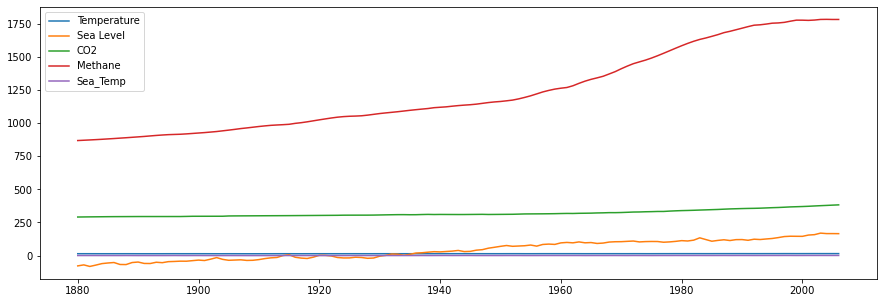

In [13]:
fig, ax = plt.subplots(figsize=(15,5))
ax.legend(plt.plot(d), ('Temperature', 'Sea Level','CO2', 'Methane', 'Sea_Temp'))


__Linear Regression Model__


-6.964824704100462


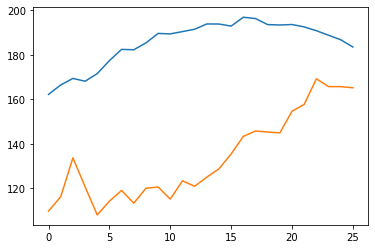

In [14]:
lreg = LinearRegression().fit(xtrain, ytrain)
prediction = lreg.predict(xtest)
print(lreg.score(xtest, ytest))
plt.plot(prediction)
plt.plot(ytest)

__MLP Regression__

In [15]:
def train():
    regr = MLPRegressor(hidden_layer_sizes=(10,), 
                        activation='relu', 
                        max_iter=20000, 
                        momentum=0.6)
    
    regr.fit(xtrain, ytrain)

    pred = regr.predict(xtest)
    tr_score = regr.score(xtrain, ytrain)
    score = regr.score(xtest, ytest)
        
    return pred, score, tr_score, regr


C:\Users\Anne\Anaconda3\envs\hack\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20000) reached and the optimization hasn't converged yet.
  warnings.warn(


not a good model


C:\Users\Anne\Anaconda3\envs\hack\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20000) reached and the optimization hasn't converged yet.
  warnings.warn(


not a good model


C:\Users\Anne\Anaconda3\envs\hack\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20000) reached and the optimization hasn't converged yet.
  warnings.warn(


not a good model
successful model


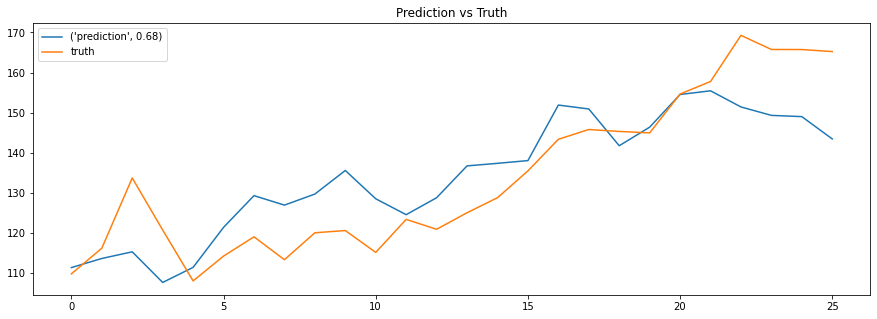

In [16]:
predictions = []
for i in range(10):
    pred, score, tr_score, regr = train()
    
    if score > -0.3: 
        print('successful model')
        predictions.append(pred)
        break
    else: 
        print('not a good model')
       

fig, _ = plt.subplots(figsize=(15,5))
plt.title('Prediction vs Truth')
plt.plot(predictions[-1], label=('prediction', np.round(score,2)))
plt.plot(ytest, label='truth')
plt.legend()

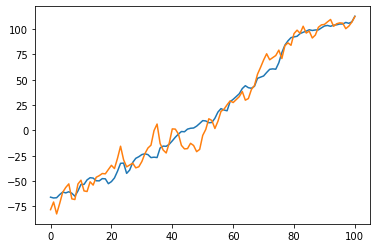

In [17]:
plt.plot(regr.predict(xtrain))
plt.plot(ytrain)

__passive aggressive regressor__

-27.090726223220205


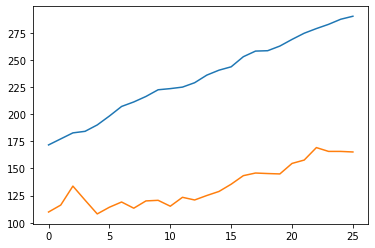

In [18]:
from sklearn.linear_model import PassiveAggressiveRegressor

par = PassiveAggressiveRegressor()
par.fit(xtrain, ytrain)

aggressive_pred = par.predict(xtest)

print(par.score(xtest, ytest))

plt.plot(aggressive_pred)
plt.plot(ytest)

__SGD Regressor__

-26.5027410767633


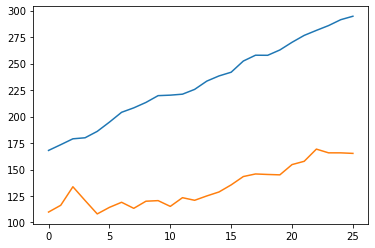

In [19]:
from sklearn.linear_model import SGDRegressor

sgd = SGDRegressor()
sgd.fit(xtrain, ytrain)

sgd_pred = sgd.predict(xtest)
print(sgd.score(xtest, ytest))

plt.plot(sgd_pred)
plt.plot(ytest)


__Kernel Ridge Regression__


0.8230305939756435 -8.487368536063219


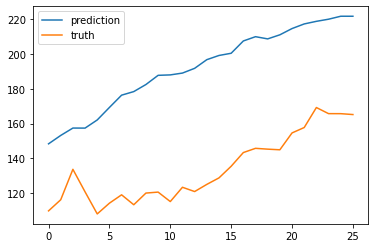

In [20]:
from sklearn.kernel_ridge import KernelRidge

kr = KernelRidge(alpha=0.3, 
                degree=1)
kr.fit(xtrain, ytrain)

kr_pred = kr.predict(xtest)
print(kr.score(xtrain, ytrain), kr.score(xtest, ytest))

plt.plot(kr_pred, label='prediction')
plt.plot(ytest, label='truth')
plt.legend()

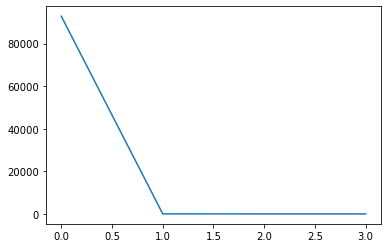

In [21]:
from sklearn.decomposition import PCA

pca = PCA(n_components=4)
comp = pca.fit_transform(ds)
comp
compo = pca.components_
var = pca.explained_variance_


plt.plot(var)